In [1]:
# imports for notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [2]:
# read in the dates and their recorded unique characteristics
dates = pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/calendar.csv', parse_dates=[0])

In [12]:
dates.drop(columns=['weekday', 'year', 'event_type_1', 'event_type_2', 'snap_TX', 'snap_WI'], inplace=True)

In [14]:
# read in the training data
val = pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/sales_train_validation.csv')

In [234]:
val['dept_id'].unique()

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

In [15]:
CA1_f2 = val[(val['store_id'] == 'CA_1')&(val['dept_id'] == 'FOODS_2')]

In [16]:
CA1_f2_melt = CA1_f2.drop(columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])

In [17]:
CA1_f2_ts = CA1_f2_melt.melt(id_vars=['id'], var_name='d', value_name='sales')

In [18]:
CA1_f2_ts

,id,d,sales
0,FOODS_2_001_CA_1_validation,d_1,0
1,FOODS_2_002_CA_1_validation,d_1,0
2,FOODS_2_003_CA_1_validation,d_1,1
3,FOODS_2_004_CA_1_validation,d_1,0
4,FOODS_2_005_CA_1_validation,d_1,1
...,...,...,...
761369,FOODS_2_395_CA_1_validation,d_1913,1
761370,FOODS_2_396_CA_1_validation,d_1913,3
761371,FOODS_2_397_CA_1_validation,d_1913,0
761372,FOODS_2_398_CA_1_validation,d_1913,0


In [19]:
CA1_f2_ts = CA1_f2_ts.merge(dates, how='inner', on='d')

In [20]:
CA1_f2_ts

,id,d,sales,date,wm_yr_wk,wday,month,event_name_1,event_name_2,snap_CA
0,FOODS_2_001_CA_1_validation,d_1,0,2011-01-29,11101,1,1,NaN,NaN,0
1,FOODS_2_002_CA_1_validation,d_1,0,2011-01-29,11101,1,1,NaN,NaN,0
2,FOODS_2_003_CA_1_validation,d_1,1,2011-01-29,11101,1,1,NaN,NaN,0
3,FOODS_2_004_CA_1_validation,d_1,0,2011-01-29,11101,1,1,NaN,NaN,0
4,FOODS_2_005_CA_1_validation,d_1,1,2011-01-29,11101,1,1,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...
761369,FOODS_2_395_CA_1_validation,d_1913,1,2016-04-24,11613,2,4,NaN,NaN,0
761370,FOODS_2_396_CA_1_validation,d_1913,3,2016-04-24,11613,2,4,NaN,NaN,0
761371,FOODS_2_397_CA_1_validation,d_1913,0,2016-04-24,11613,2,4,NaN,NaN,0
761372,FOODS_2_398_CA_1_validation,d_1913,0,2016-04-24,11613,2,4,NaN,NaN,0


In [22]:
CA1_f2_ts.set_index('date', inplace=True)

In [23]:
CA1_f2_ts.loc['2011-01-30']

,id,d,sales,wm_yr_wk,wday,month,event_name_1,event_name_2,snap_CA
date,,,,,,,,,
2011-01-30,FOODS_2_001_CA_1_validation,d_2,0,11101,2,1,NaN,NaN,0
2011-01-30,FOODS_2_002_CA_1_validation,d_2,0,11101,2,1,NaN,NaN,0
2011-01-30,FOODS_2_003_CA_1_validation,d_2,2,11101,2,1,NaN,NaN,0
2011-01-30,FOODS_2_004_CA_1_validation,d_2,0,11101,2,1,NaN,NaN,0
2011-01-30,FOODS_2_005_CA_1_validation,d_2,1,11101,2,1,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
2011-01-30,FOODS_2_395_CA_1_validation,d_2,0,11101,2,1,NaN,NaN,0
2011-01-30,FOODS_2_396_CA_1_validation,d_2,0,11101,2,1,NaN,NaN,0
2011-01-30,FOODS_2_397_CA_1_validation,d_2,0,11101,2,1,NaN,NaN,0


In [24]:
CA1_f2_ts['lag_1'] = CA1_f2_ts['sales'].shift(periods=398)

In [25]:
CA1_f2_ts['lag_2'] = CA1_f2_ts['sales'].shift(periods=(398*2))

In [26]:
CA1_f2_ts['lag_3'] = CA1_f2_ts['sales'].shift(periods=(398*3))

In [27]:
CA1_f2_ts['lag_4'] = CA1_f2_ts['sales'].shift(periods=(398*4))

In [28]:
CA1_f2_ts['lag_5'] = CA1_f2_ts['sales'].shift(periods=(398*5))

In [29]:
CA1_f2_ts['lag_6'] = CA1_f2_ts['sales'].shift(periods=(398*6))

In [30]:
CA1_f2_ts['lag_7'] = CA1_f2_ts['sales'].shift(periods=(398*7))

In [31]:
CA1_f2_ts['lag_14'] = CA1_f2_ts['sales'].shift(periods=(398*14))

In [32]:
CA1_f2_ts['lag_21'] = CA1_f2_ts['sales'].shift(periods=(398*21))

In [33]:
CA1_f2_ts['lag_28'] = CA1_f2_ts['sales'].shift(periods=(398*28))

In [34]:
CA1_f2_ts

,id,d,sales,wm_yr_wk,wday,month,event_name_1,event_name_2,snap_CA,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_14,lag_21,lag_28
date,,,,,,,,,,,,,,,,,,,
2011-01-29,FOODS_2_001_CA_1_validation,d_1,0,11101,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-29,FOODS_2_002_CA_1_validation,d_1,0,11101,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-29,FOODS_2_003_CA_1_validation,d_1,1,11101,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-29,FOODS_2_004_CA_1_validation,d_1,0,11101,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-29,FOODS_2_005_CA_1_validation,d_1,1,11101,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-24,FOODS_2_395_CA_1_validation,d_1913,1,11613,2,4,NaN,NaN,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-04-24,FOODS_2_396_CA_1_validation,d_1913,3,11613,2,4,NaN,NaN,0,2.0,2.0,3.0,1.0,1.0,4.0,4.0,3.0,0.0,0.0
2016-04-24,FOODS_2_397_CA_1_validation,d_1913,0,11613,2,4,NaN,NaN,0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0


In [35]:
train = CA1_f2_ts['2014-03-28':'2016-03-28']

In [36]:
test = CA1_f2_ts['2016-03-28':]

In [37]:
X_train = train.drop(['sales', 'd', 'wm_yr_wk', 'event_name_1', 'event_name_2'], axis=1)
X_test = test.drop(['sales', 'd', 'wm_yr_wk', 'event_name_1', 'event_name_2'], axis=1)
y_train = train['sales']
y_test = test['sales']

In [38]:
label = LabelEncoder()
X_train['id'] = label.fit_transform(X_train['id'])
X_test['id'] = label.transform(X_test['id'])

In [39]:
rf1 = RandomForestRegressor(max_depth=20)
rf1.fit(X_train, y_train)

RandomForestRegressor(max_depth=20)

In [40]:
rf1.score(X_train, y_train)

0.8773686786292976

In [41]:
rf1.score(X_test, y_test)

0.560927656624282

In [42]:
rf1_preds = rf1.predict(X_test)

In [43]:
rf1_preds = pd.Series(rf1_preds).set_axis(y_test.index)

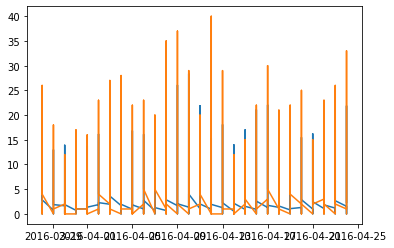

In [44]:
fig, ax = plt.subplots()
ax.plot(rf1_preds)
ax.plot(y_test)

In [45]:
mean_squared_error(rf1_preds, y_test, squared=False)

1.6682648960664146

In [46]:
lgbm_1 = LGBMRegressor()
lgbm_1.fit(X_train, y_train)

LGBMRegressor()

In [47]:
lgbm_1.score(X_train, y_train)

0.639175299633108

In [48]:
lgbm_1.score(X_test, y_test)

0.5649299947710789

In [50]:
lgbm_preds = lgbm_1.predict(X_test)

In [53]:
lgbm_preds = pd.Series(lgbm_preds).set_axis(y_test.index)

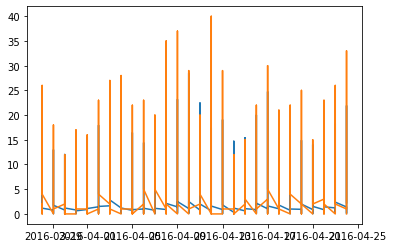

In [54]:
fig, ax = plt.subplots()
ax.plot(lgbm_preds)
ax.plot(y_test)

In [57]:
mean_squared_error(y_test, lgbm_preds, squared=False)

1.6606440040421349

In [49]:
xgb_1 = XGBRegressor()
xgb_1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
xgb_1.score(X_train, y_train)

0.6939032136964218

In [52]:
xgb_1.score(X_test, y_test)

0.5562607309318895

In [58]:
xgb_preds = xgb_1.predict(X_test)

In [59]:
xgb_preds = pd.Series(xgb_preds).set_axis(y_test.index)

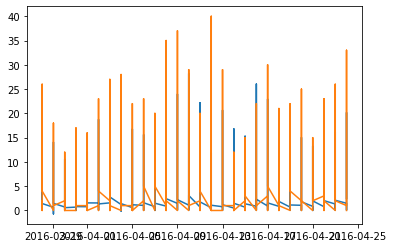

In [60]:
fig, ax = plt.subplots()
ax.plot(xgb_preds)
ax.plot(y_test)

In [61]:
mean_squared_error(y_test, xgb_preds, squared=False)

1.6771075037438203